In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from imageio import imread
from torchvision. transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn as nn
import torch. nn.functional as F
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from collections import defaultdict


In [ ]:
class CCPDataset(Dataset):
    """
    Dataset para segmentación semántica multiclase. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', y opcionalmente 'coords'
        patch_size: Tamaño del patch a extraer
        transforms: Lista [joint_transform, image_transform] donde:
            - joint_transform: se aplica a imagen y máscara (ej: flips, rotaciones)
            - image_transform: se aplica solo a imagen (ej: normalización)
        mode: 'train' (random crop), 'eval' (crop con coords), 'full' (imagen completa)
        class_dict_path: Ruta al CSV con columnas 'r', 'g', 'b' para mapeo de colores
    """

    def __init__(self, df, patch_size=224, transforms=None, mode='train', class_dict_path='clothes/class_dict.csv'):
        super(CCPDataset, self).__init__()
        self.df = df. reset_index(drop=True)
        self.ps = patch_size
        self. transforms = transforms
        self.mode = mode

        # Cargar diccionario de clases
        class_df = pd.read_csv(class_dict_path)
        
        # Crear mapping RGB -> class_id usando bit packing
        r = class_df['r'].to_numpy(dtype=np.uint32)
        g = class_df['g'].to_numpy(dtype=np.uint32)
        b = class_df['b'].to_numpy(dtype=np.uint32)

        keys = (r << 16) | (g << 8) | b

        self.color_to_class = dict(zip(keys. tolist(), range(len(keys))))
        self.num_classes = len(self.color_to_class)
        
        # Guardar nombres de clases si están disponibles
        if 'class_name' in class_df.columns:
            self.class_names = class_df['class_name']. tolist()
            if self.class_names[0] == 'null':
                self.class_names[0] = 'background'
        else:
            self.class_names = [f'class_{i}' for i in range(self.num_classes)]

    def mask_rgb_to_ids(self, mask):
        """
        Convierte máscara RGB a índices de clase usando bit packing.
        Colores no encontrados se mapean a clase 0 (background).
        """
        packed = (mask[...,0].astype(np.uint32) << 16) | \
                 (mask[...,1].astype(np.uint32) << 8)  | \
                  mask[...,2].astype(np.uint32)
        
        # Verificar colores desconocidos (opcional, comentar si no necesitas warnings)
        unique_packed = np.unique(packed)
        unknown = [p for p in unique_packed if p not in self.color_to_class]
        if unknown and self.mode == 'train':  # Solo warning en train para no saturar logs
            unknown_colors = [(p >> 16, (p >> 8) & 0xFF, p & 0xFF) for p in unknown[:3]]
            print(f"Warning: Found {len(unknown)} unknown colors (showing first 3): {unknown_colors}")
        
        mapped = np.vectorize(self.color_to_class.get)(packed, 0)
        return mapped. astype(np.int64)

    def __random_crop__(self, img, mask):
        """Extrae un crop aleatorio de tamaño self.ps"""
        H, W = img. shape[:2]
        
        if H < self.ps or W < self. ps:
            # Padding si la imagen es más pequeña que el patch
            pad_h = max(0, self.ps - H)
            pad_w = max(0, self.ps - W)
            img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            mask = np.pad(mask, ((0, pad_h), (0, pad_w), (0, 0)) if mask. ndim == 3 else ((0, pad_h), (0, pad_w)), mode='reflect')
            H, W = img.shape[:2]
        
        # Random top-left corner
        top = np.random.randint(0, H - self.ps + 1)
        left = np.random.randint(0, W - self.ps + 1)
        
        # Extract patch
        img_patch = img[top:top+self.ps, left:left+self.ps]
        mask_patch = mask[top:top+self.ps, left:left+self.ps]
        
        return img_patch, mask_patch

    def __getitem__(self, idx):
        r = self.df. iloc[idx]

        # Leer imagen y máscara
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Aplicar crop según el modo
        if self.mode == 'train':
            # Random crop para entrenamiento
            x, y = self.__random_crop__(x, y)
            
        elif self.mode == 'eval':
            # Crop con coordenadas específicas para evaluación
            if 'coords' in r and r.coords is not None:
                x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            else:
                # Si no hay coords, tomar centro
                H, W = x.shape[:2]
                top = max(0, (H - self.ps) // 2)
                left = max(0, (W - self.ps) // 2)
                x = x[top:top+self.ps, left:left+self.ps]
                y = y[top:top+self.ps, left:left+self.ps]
        
        # mode == 'full': no hacer crop, usar imagen completa

        # Convertir máscara RGB a IDs de clase
        if y.ndim == 3 and y.shape[2] == 3:
            y = self.mask_rgb_to_ids(y)
        else:
            y = y.astype(np.int64)

        # Convertir a PIL para aplicar transforms
        x = to_pil_image(x. astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')

        # Aplicar transformaciones
        if self. transforms:
            if isinstance(self.transforms, list):
                # Formato: [joint_transform, image_transform]
                if self.transforms[0] is not None:
                    x, y = self.transforms[0](x, y)
                if self.transforms[1] is not None:
                    x = self. transforms[1](x)
            else:
                # Solo image transform
                x = self.transforms(x)

        # Convertir a tensors
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(np.array(x)). permute(2, 0, 1).float() / 255.0
        
        y = torch.from_numpy(np.array(y, dtype=np.int64))

        return x, y

    def __len__(self):
        return self.df.shape[0]

    def __show_item__(self, x, y, denormalize=None):
        """
        Visualiza una muestra del dataset.
        
        Args:
            x: Tensor de imagen (C, H, W)
            y: Tensor de máscara (H, W)
            denormalize: Función para desnormalizar la imagen (opcional)
        """
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Desnormalizar imagen si es necesario
        if denormalize is not None:
            x_vis = denormalize(x)
        else:
            x_vis = x
        
        # Asegurar que x esté en rango [0, 1]
        x_vis = x_vis.permute(1, 2, 0).cpu().numpy()
        if x_vis.max() > 1.0:
            x_vis = x_vis / 255.0
        x_vis = np.clip(x_vis, 0, 1)

        y_vis = y.cpu().numpy()

        ax[0].imshow(x_vis)
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(y_vis, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[1]. set_title('Mask')
        ax[1].axis('off')

        ax[2].imshow(x_vis)
        ax[2].imshow(y_vis, alpha=0.5, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[2].set_title('Overlay')
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
class DataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule para segmentación semántica. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', 'set'
        class_dict_path: Ruta al CSV con clases
        bs: Batch size
        ps: Patch size
        num_workers: Número de workers para DataLoader
    """
    
    def __init__(self, df, class_dict_path='clothes/class_dict.csv', bs=16, ps=256, num_workers=8):
        super().__init__()
        self.df = df
        self.class_dict_path = class_dict_path
        self.bs = bs
        self.ps = ps
        self. num_workers = num_workers
        
        # Cargar número de clases
        class_df = pd.read_csv(class_dict_path)
        self.num_classes = len(class_df)

    def setup(self, stage=None):
        """Preparar datasets con transforms apropiados"""
        
        # Transforms para normalización (solo imagen)
        normalize_transform = T.Compose([
            T.ToTensor(),
            T. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Para train: sin joint transforms (podrías agregar data augmentation aquí)
        train_transforms = [None, normalize_transform]
        
        # Para val/test: solo normalización
        eval_transforms = [None, normalize_transform]
        
        # Crear datasets
        self.train_ds = CCPDataset(
            df=self.df. query('set == "train"'). reset_index(drop=True),
            patch_size=self. ps,
            transforms=train_transforms,
            mode='train',
            class_dict_path=self.class_dict_path
        )
        
        self. valid_ds = CCPDataset(
            df=self.df. query('set == "valid"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='train',  # También random crop en validación
            class_dict_path=self.class_dict_path
        )
        
        self.test_ds = CCPDataset(
            df=self. df.query('set == "test"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='full',  # Imagen completa para test
            class_dict_path=self.class_dict_path
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.bs,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.bs,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=1,  # Batch size 1 para imágenes completas
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    @staticmethod
    def patch_origins(h, w, ps, overlap=2):
        """
        Genera coordenadas de origen para patches con overlap.
        
        Args:
            h, w: Alto y ancho de la imagen
            ps: Tamaño del patch
            overlap: Factor de overlap (overlap=2 significa 50% de overlap)
        
        Returns:
            Array de coordenadas (x, y) de origen de cada patch
        """
        stride = ps // overlap
        origins = []
        
        for x in range(0, h - ps + 1, stride):
            for y in range(0, w - ps + 1, stride):
                origins.append([x, y])
        
        # Agregar bordes si no están cubiertos
        if (h - ps) % stride != 0:
            for y in range(0, w - ps + 1, stride):
                origins.append([h - ps, y])
        
        if (w - ps) % stride != 0:
            for x in range(0, h - ps + 1, stride):
                origins.append([x, w - ps])
        
        # Esquina inferior derecha
        if (h - ps) % stride != 0 and (w - ps) % stride != 0:
            origins. append([h - ps, w - ps])
        
        return np.array(origins)

In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from collections import defaultdict


class SegmentationModel(pl.LightningModule):
    """
    PyTorch Lightning Module para segmentación semántica multiclase.
    
    Args:
        num_classes: Número de clases de segmentación
        encoder_name: Nombre del encoder (ej: 'resnet18', 'resnet50', 'efficientnet-b0')
        encoder_weights: Pesos pre-entrenados (ej: 'imagenet')
        learning_rate: Learning rate para el optimizador
        architecture: Arquitectura del modelo ('unet', 'deeplabv3+', 'fpn', 'pspnet')
    """
    
    def __init__(self, num_classes, encoder_name='resnet50', encoder_weights='imagenet', 
                 learning_rate=1e-3, architecture='unet'):
        super().__init__()
        self.save_hyperparameters()
        
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.architecture = architecture
        
        # Crear modelo según arquitectura
        if architecture == 'unet':
            print("UNETE")
            self.model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'deeplabv3+':
            print("UNETE NO")
            self.model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'fpn':
            print("UNETE NO")
            self.model = smp.FPN(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'pspnet':
            print("UNETE NO")
            self.model = smp.PSPNet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        else:
            raise ValueError(f"Architecture {architecture} not supported. Choose from: 'unet', 'deeplabv3+', 'fpn', 'pspnet'")
        
        # Métricas - IoU y Dice (F1)
        # Use compute_on_cpu=True to avoid GPU memory issues with large number of classes
        self.train_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro', compute_on_cpu=True)
        self.val_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro', compute_on_cpu=True)
        self.train_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None, compute_on_cpu=True)
        self.val_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None, compute_on_cpu=True)
        
        self.train_dice = MulticlassF1Score(num_classes=num_classes, average='macro', compute_on_cpu=True)
        self.val_dice = MulticlassF1Score(num_classes=num_classes, average='macro', compute_on_cpu=True)
        
        # Métricas acumuladas por época
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss = F.cross_entropy(logits, y)
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)
        
        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['acc'] += acc.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss = F.cross_entropy(logits, y)
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)
        
        # Actualizar IoU per-class
        self.val_iou_per_class.update(preds, y)
        
        # Logging
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['acc'] += acc.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self):
        if self.training_step_outputs['steps'] > 0:
            avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
            avg_acc = self.training_step_outputs['acc'] / self.training_step_outputs['steps']
            
            # Obtener métricas finales
            train_iou = self.train_iou.compute()
            train_dice = self.train_dice.compute()
            train_iou_per_class = self.train_iou_per_class.compute()
            
            print(f"\nEpoch {self.current_epoch} - Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(train_iou_per_class):
                self.log(f'train_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.train_iou.reset()
            self.train_dice.reset()
            self.train_iou_per_class.reset()
            
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        if self.validation_step_outputs['steps'] > 0:
            avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
            avg_acc = self.validation_step_outputs['acc'] / self.validation_step_outputs['steps']
            
            # Obtener métricas finales
            val_iou = self.val_iou.compute()
            val_dice = self.val_dice.compute()
            val_iou_per_class = self.val_iou_per_class.compute()
            
            print(f"Epoch {self.current_epoch} - Val Loss: {avg_loss:.4f}, Val Acc: {avg_acc:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(val_iou_per_class):
                self.log(f'val_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.val_iou.reset()
            self.val_dice.reset()
            self.val_iou_per_class.reset()
            
        self.validation_step_outputs.clear()

Total images: 1004
set
train    700
test     154
valid    150
Name: count, dtype: int64
                       image_path                       mask_path   set
0  ./clothes/test/images/0851.jpg  ./clothes/test/labels/0851.png  test
1  ./clothes/test/images/0852.jpg  ./clothes/test/labels/0852.png  test
2  ./clothes/test/images/0853.jpg  ./clothes/test/labels/0853.png  test
3  ./clothes/test/images/0854.jpg  ./clothes/test/labels/0854.png  test
4  ./clothes/test/images/0855.jpg  ./clothes/test/labels/0855.png  test

Dataset Classes:
 0. background           - RGB: [69, 6, 90]
 1. accessories          - RGB: [70, 12, 95]
 2. bag                  - RGB: [71, 18, 101]
 3. belt                 - RGB: [72, 25, 107]
 4. blazer               - RGB: [72, 30, 112]
 5. blouse               - RGB: [72, 35, 116]
 6. bodysuit             - RGB: [71, 40, 120]
 7. boots                - RGB: [70, 47, 124]
 8. bra                  - RGB: [69, 52, 127]
 9. bracelet             - RGB: [68, 57, 130]
10. c

/tmp/ipykernel_453610/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453610/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


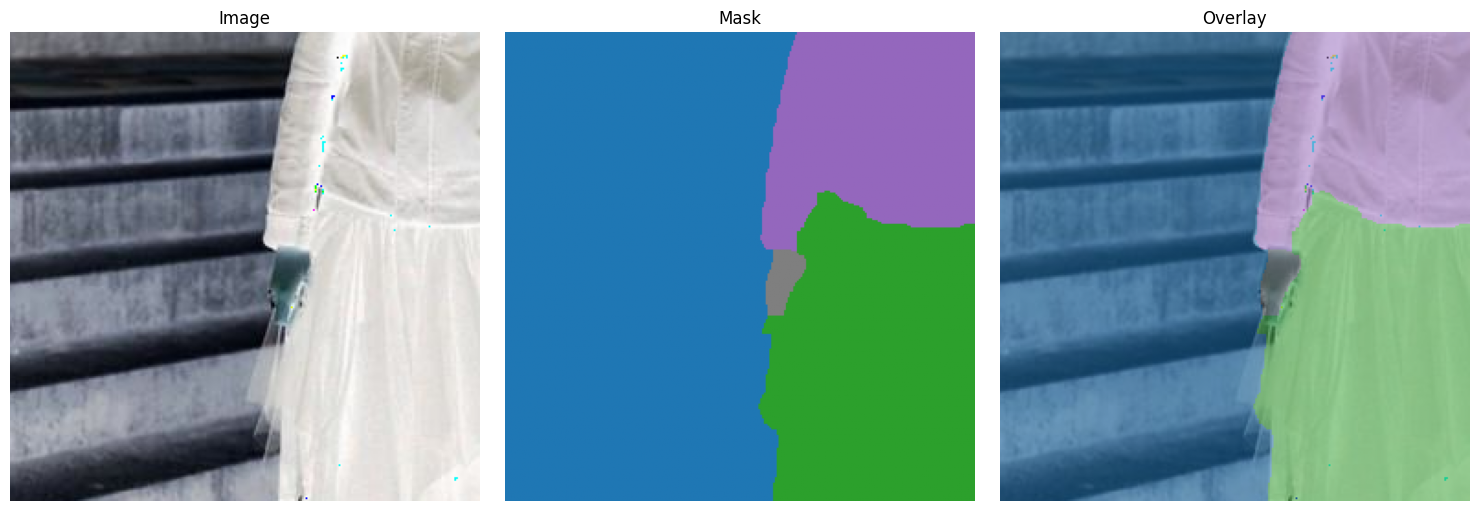


Sample 1:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 13, 31, 48]


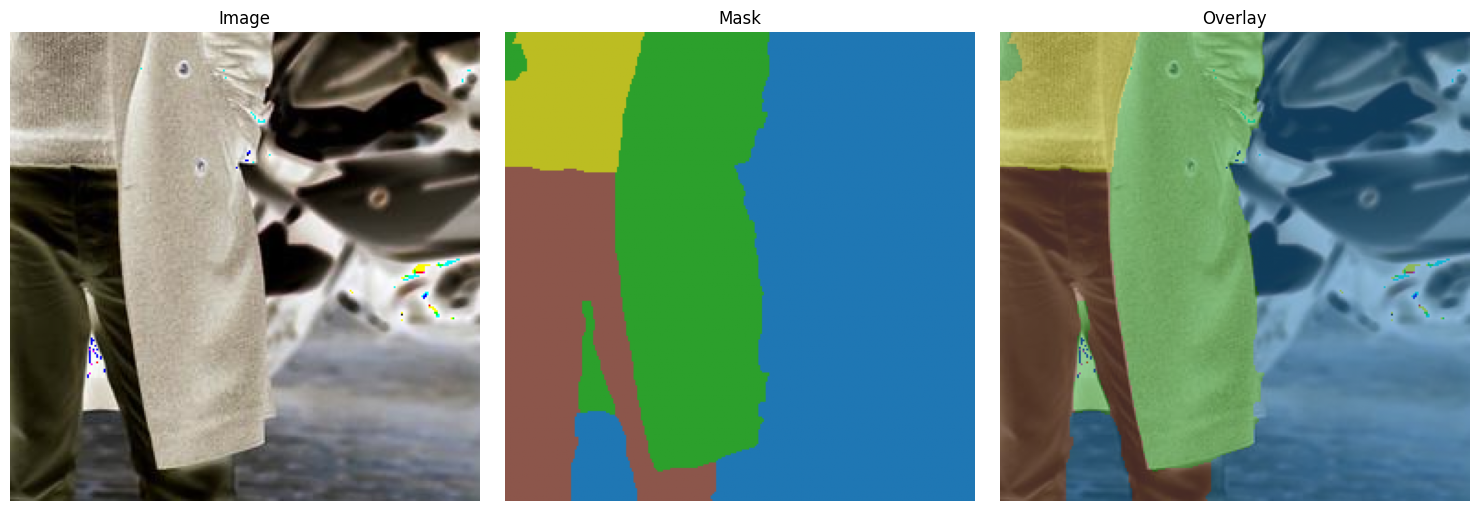


Sample 2:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 10, 14, 33, 39, 41, 55]


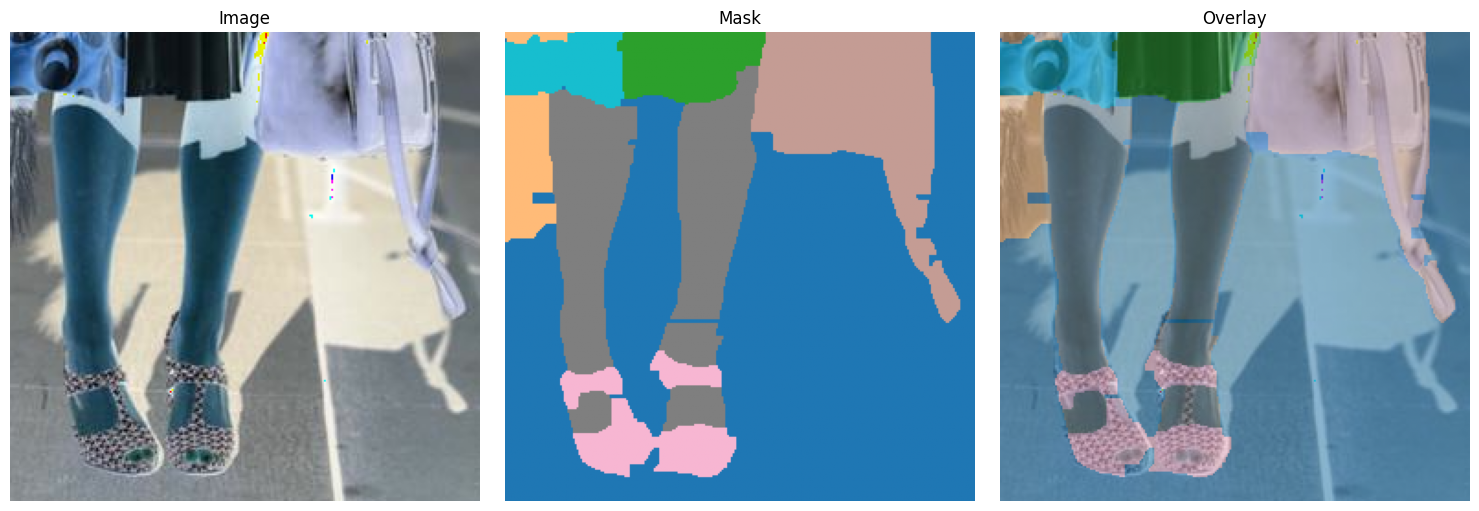

In [ ]:
import glob
import pandas as pd
import os

# ============================================
# 1.  PREPARAR DATOS
# ============================================

DATA_DIR = 'clothes'

# Cargar imágenes
images = glob.glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df. image_path.apply(lambda x: x.replace('/images/', '/labels/'). replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x: x.split('/')[2])

print(f"Total images: {len(df)}")
print(df['set'].value_counts())
print(df. head())

# Cargar diccionario de clases
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_names = class_dict['class_name'].tolist()
class_names[0] = 'background'  # Renombrar 'null' a 'background'
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('\n' + '='*50)
print('Dataset Classes:')
print('='*50)
for i, (name, rgb) in enumerate(zip(class_names, class_rgb_values)):
    print(f"{i:2d}. {name:20s} - RGB: {rgb}")
print('='*50 + '\n')

# ============================================
# 2. CREAR DATAMODULE
# ============================================

dm = DataModule(
    df=df,
    class_dict_path=os.path.join(DATA_DIR, 'class_dict.csv'),
    bs=16,
    ps=256,
    num_workers=4  # Ajusta según tu CPU
)

dm.setup()

print(f"Train samples: {len(dm.train_ds)}")
print(f"Valid samples: {len(dm. valid_ds)}")
print(f"Test samples: {len(dm.test_ds)}")
print(f"Number of classes: {dm.num_classes}")

# ============================================
# 3.  VISUALIZAR MUESTRAS
# ============================================
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Desnormaliza una imagen normalizada con mean y std de ImageNet.
    
    Args:
        image (Tensor): Imagen normalizada (C, H, W)
        mean (list): Valores de media usados en normalización
        std (list): Valores de desviación estándar usados en normalización
    
    Returns:
        Tensor: Imagen desnormalizada en rango [0, 1]
    """
    # Asegurar que sea tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    
    # Crear tensores de mean y std con la forma correcta
    mean = torch.tensor(mean, dtype=image.dtype, device=image.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=image.dtype, device=image.device).view(3, 1, 1)
    
    # Desnormalizar: x = (x * std) + mean
    image = image * std + mean
    
    # Asegurar que esté en rango [0, 1]
    image = torch.clamp(image, 0, 1)
    
    return image

# Visualizar algunas muestras de entrenamiento
for i in range(3):
    x, y = dm.train_ds[i]
    print(f"\nSample {i}:")
    print(f"Image shape: {x.shape}")
    print(f"Mask shape: {y.shape}")
    print(f"Unique classes in mask: {torch.unique(y). tolist()}")

    # Asegurarse de que x sea un tensor de PyTorch antes de llamar a permute
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    dm.train_ds.__show_item__(x, y, denormalize=denormalize_image)

In [ ]:
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

# Memory optimization settings
torch.set_float32_matmul_precision('medium')  # Use Tensor Cores efficiently
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  # Better memory management

# Configuration
ARCHITECTURE = 'unet'  # Change to: 'unet', 'deeplabv3+', 'fpn', 'pspnet'
ENCODER_NAME = 'resnet50'
LEARNING_RATE = 1e-3
MAX_EPOCHS = 1
BATCH_SIZE = 32  # Reduced from 64 to save memory
PATCH_SIZE = 224
CLASS_DICT_PATH = 'clothes/class_dict.csv'
NUM_WORKERS = 2

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Load the data module first to get num_classes
data_module = DataModule(df, class_dict_path=CLASS_DICT_PATH, bs=BATCH_SIZE, ps=PATCH_SIZE, num_workers=NUM_WORKERS)
data_module.setup()

# Get number of classes from data module
NUM_CLASSES = data_module.num_classes

# Instantiate the SegmentationModel
model = SegmentationModel(
    num_classes=NUM_CLASSES,
    encoder_name=ENCODER_NAME,
    encoder_weights='imagenet',
    learning_rate=LEARNING_RATE,
    architecture=ARCHITECTURE
)

# Define a CSV logger with folder structure
# This will create: experiments/unet/version_0/metrics.csv
csv_logger = CSVLogger(
    save_dir='experiments',
    name=ARCHITECTURE,
    version=None  # Auto-increment version numbers
)

# Define checkpoint callbacks
# Best model based on validation loss
checkpoint_val_loss = ModelCheckpoint(
    dirpath=f'experiments/{ARCHITECTURE}/checkpoints',
    filename='best_val_loss-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    verbose=True
)

# Best model based on validation IoU
checkpoint_val_iou = ModelCheckpoint(
    dirpath=f'experiments/{ARCHITECTURE}/checkpoints',
    filename='best_val_iou-{epoch:02d}-{val_iou:.4f}',
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    verbose=True
)

# Save last checkpoint
checkpoint_last = ModelCheckpoint(
    dirpath=f'experiments/{ARCHITECTURE}/checkpoints',
    filename='last-{epoch:02d}',
    save_last=True,
    verbose=True
)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=csv_logger,
    callbacks=[checkpoint_val_loss, checkpoint_val_iou, checkpoint_last],
    accelerator='auto',  # Automatically use GPU if available
    devices=1,
    deterministic='warn',  # Use 'warn' instead of True for better compatibility
    log_every_n_steps=10,
    gradient_clip_val=1.0,  # Gradient clipping for stability
    precision='16-mixed'  # Mixed precision training for memory efficiency
)

# Train the model (data_module already loaded)
trainer.fit(model, data_module)

# Print best model paths
print(f"\n{'='*60}")
print(f"Training completed for {ARCHITECTURE}!")
print(f"Best model (val_loss): {checkpoint_val_loss.best_model_path}")
print(f"Best model (val_iou): {checkpoint_val_iou.best_model_path}")
print(f"Last checkpoint: {checkpoint_last.last_model_path}")
print(f"{'='*60}\n")

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | model               | Unet                   | 32.5 M | train
1 | train_iou           | MulticlassJaccardIndex | 0      | train
2 | val_iou             | MulticlassJaccardIndex | 0      | train
3 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
4 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
5 | train_dice          | MulticlassF1Score      | 0      | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453610/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453610/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453610/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453610/2253632455.py:89: DeprecationWa

Epoch 0 - Val Loss: 4.1180, Val Acc: 0.0057, Val IoU: 0.0014, Val Dice: 0.0028


/tmp/ipykernel_453610/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453610/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453610/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453610/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


OutOfMemoryError: CUDA out of memory. Tried to allocate 41.64 GiB. GPU 0 has a total capacity of 94.97 GiB of which 41.55 GiB is free. Process 265685 has 1.21 GiB memory in use. Including non-PyTorch memory, this process has 50.85 GiB memory in use. Of the allocated memory 50.16 GiB is allocated by PyTorch, and 42.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)